Version 1.0.1

# Check your versions

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn, lightgbm]:
    print (p.__name__, p.__version__)

('numpy', '1.13.3')
('pandas', u'0.18.1')
('scipy', '1.0.0')
('sklearn', '0.18.1')
('lightgbm', '2.0.6')


**Important!** There is a huge chance that the assignment will be impossible to pass if the versions of `lighgbm` and `scikit-learn` are wrong. The versions being tested:

    numpy 1.13.1
    pandas 0.20.3
    scipy 0.19.1
    sklearn 0.19.0
    ligthgbm 2.0.6
    

To install an older version of `lighgbm` you may use the following command:
```
pip uninstall lightgbm
pip install lightgbm==2.0.6
```

# Ensembling

In this programming assignment you are asked to implement two ensembling schemes: simple linear mix and stacking.

We will spend several cells to load data and create feature matrix, you can scroll down this part or try to understand what's happening.

In [2]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load data subset

Let's load the data from the hard drive first.

In [3]:
sales = pd.read_csv('./sales_train.csv.gz')
shops = pd.read_csv('./shops.csv')
items = pd.read_csv('./items.csv')
item_cats = pd.read_csv('./item_categories.csv')
test = pd.read_csv('./test.csv.gz')

In [27]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


And use only 3 shops for simplicity.

In [4]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

# Get a feature matrix

We now need to prepare the features. This part is all implemented for you.

In [5]:
from itertools import product
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [6]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=1000]

In [7]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()
sales_m = pd.merge(grid,sales_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
# adding the category id too
sales_m = pd.merge(sales_m,items,on=['item_id'],how='left')

for type_id in ['item_id','shop_id','item_category_id']:
    for column_id,aggregator,aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:

        mean_df = sales_m.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']

        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num',type_id],how='left')

In [8]:
sales_m = downcast_dtypes(sales_m)

In [9]:
gc.collect()

407

In [10]:
sales_means = sales_m

In [11]:
[str(i) for i in sales_m.columns]

['shop_id',
 'item_id',
 'date_block_num',
 'item_price',
 'item_cnt_day',
 'item_name',
 'item_category_id',
 'item_id_avg_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_avg_item_cnt_day',
 'shop_id_avg_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_avg_item_cnt_day',
 'item_category_id_avg_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_avg_item_cnt_day']

In [12]:
import gc

In [13]:
lag_variables  = list(sales_m.columns[7:])+['item_cnt_day']
lags = [1 ,2 ,3 ,4]#, 5, 12]
sales_means = sales_m[['date_block_num','shop_id','item_id']]
for lag in lags:
    print(lag)
    gc.collect()
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    sales_means = pd.merge(sales_means, sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')

1
2
3
4


In [14]:
[str(i) for i in sales_means.columns]

['date_block_num',
 'shop_id',
 'item_id',
 'item_id_avg_item_price_lag_1',
 'item_id_sum_item_cnt_day_lag_1',
 'item_id_avg_item_cnt_day_lag_1',
 'shop_id_avg_item_price_lag_1',
 'shop_id_sum_item_cnt_day_lag_1',
 'shop_id_avg_item_cnt_day_lag_1',
 'item_category_id_avg_item_price_lag_1',
 'item_category_id_sum_item_cnt_day_lag_1',
 'item_category_id_avg_item_cnt_day_lag_1',
 'item_cnt_day_lag_1',
 'item_id_avg_item_price_lag_2',
 'item_id_sum_item_cnt_day_lag_2',
 'item_id_avg_item_cnt_day_lag_2',
 'shop_id_avg_item_price_lag_2',
 'shop_id_sum_item_cnt_day_lag_2',
 'shop_id_avg_item_cnt_day_lag_2',
 'item_category_id_avg_item_price_lag_2',
 'item_category_id_sum_item_cnt_day_lag_2',
 'item_category_id_avg_item_cnt_day_lag_2',
 'item_cnt_day_lag_2',
 'item_id_avg_item_price_lag_3',
 'item_id_sum_item_cnt_day_lag_3',
 'item_id_avg_item_cnt_day_lag_3',
 'shop_id_avg_item_price_lag_3',
 'shop_id_sum_item_cnt_day_lag_3',
 'shop_id_avg_item_cnt_day_lag_3',
 'item_category_id_avg_item_price

In [15]:
for feat in sales_means.columns:
    if 'item_cnt' in feat:
        sales_means[feat]=sales_means[feat].fillna(0)
    elif 'item_price' in feat:
        sales_means[feat]=sales_means[feat].fillna(sales_means[feat].median())

In [16]:
cols_to_drop = lag_variables[:-1] + ['item_name','item_price']


In [17]:
cols_to_drop

['item_id_avg_item_price',
 'item_id_sum_item_cnt_day',
 'item_id_avg_item_cnt_day',
 'shop_id_avg_item_price',
 'shop_id_sum_item_cnt_day',
 'shop_id_avg_item_cnt_day',
 'item_category_id_avg_item_price',
 'item_category_id_sum_item_cnt_day',
 'item_category_id_avg_item_cnt_day',
 'item_name',
 'item_price']

In [18]:
sales_means = sales_means[sales_means['date_block_num']>12]


In [19]:
sales_means = pd.merge(sales_means, sales_m[['date_block_num','shop_id','item_id', 'item_cnt_day']], how='left', on=['date_block_num','shop_id','item_id'])

In [20]:
gc.collect()

64

In [54]:
X_train.apply?

In [21]:
X_train = sales_means[sales_means['date_block_num']<33].drop(['item_cnt_day'], axis=1)
X_cv =  sales_means[sales_means['date_block_num']==33].drop(['item_cnt_day'], axis=1)

y_train = sales_means[sales_means['date_block_num']<33]['item_cnt_day']
y_cv =  sales_means[sales_means['date_block_num']==33]['item_cnt_day']


In [22]:
def clip(x):
    if x>40:
        return 40
    elif x<0:
        return 0
    else:
        return x

In [23]:
y_train_clip = y_train.apply(lambda x: clip(x))
y_cv_clip = y_cv.apply(lambda x: clip(x))


In [24]:
del sales_means

In [25]:
gc.collect()

7

In [26]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import numpy as np

reload(hp)

def objective(space):
    print(space)
    clf = xgb.XGBRegressor(n_estimators =1000,colsample_bytree=space['colsample_bytree'],
                           learning_rate = .3,
                            max_depth = int(space['max_depth']),
                            min_child_weight = space['min_child_weight'],
                            subsample = space['subsample'],
                           gamma = space['gamma'],
                           reg_lambda = space['reg_lambda'],)

    eval_set  = [( X_train, y_train_clip), ( X_cv, y_cv_clip)]

    clf.fit(X_train, y_train_clip,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = clf.predict(X_cv)
    mse_scr = mean_squared_error(y_cv_clip, pred)
    print "SCORE:", np.sqrt(mse_scr)
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }


space ={'max_depth': hp.quniform("x_max_depth", 4, 16, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.7,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1)
    }


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print best

{'subsample': 0.7826404634156052, 'reg_lambda': 0.8332637293340572, 'colsample_bytree': 0.9701058959382172, 'gamma': 0.4566482743916861, 'max_depth': 13.0, 'min_child_weight': 2.0}
SCORE: 2.19677187458
{'subsample': 0.9754653799527666, 'reg_lambda': 0.909594537391344, 'colsample_bytree': 0.7100151097556978, 'gamma': 0.15201995200965898, 'max_depth': 15.0, 'min_child_weight': 5.0}
SCORE: 2.04993039371
{'subsample': 0.7338207117177693, 'reg_lambda': 0.3626345889684013, 'colsample_bytree': 0.819892028538395, 'gamma': 0.4120292307413289, 'max_depth': 5.0, 'min_child_weight': 5.0}
SCORE: 2.11177430485
{'subsample': 0.9462072992990606, 'reg_lambda': 0.5640129058487335, 'colsample_bytree': 0.9912994983005678, 'gamma': 0.3983731734684385, 'max_depth': 5.0, 'min_child_weight': 3.0}
SCORE: 2.15742887082
{'subsample': 0.9143571228062765, 'reg_lambda': 0.46267597896480217, 'colsample_bytree': 0.8317665317022381, 'gamma': 0.2734378099832939, 'max_depth': 14.0, 'min_child_weight': 4.0}
SCORE: 2.0992

KeyboardInterrupt: 

In [26]:
test_copy = test.copy()
test_copy['date_block_num'] = 34
test_copy.drop(['ID'], axis=1, inplace=True)
all_data = pd.concat([all_data, test_copy], axis=0)

In [24]:
all_data = sales_means

In [27]:
all_data.head()

,date_block_num,item_category_id_avg_item_cnt_day_lag_1,item_category_id_avg_item_cnt_day_lag_2,item_category_id_avg_item_cnt_day_lag_3,item_category_id_avg_item_cnt_day_lag_4,item_category_id_avg_item_price_lag_1,item_category_id_avg_item_price_lag_2,item_category_id_avg_item_price_lag_3,item_category_id_avg_item_price_lag_4,item_category_id_sum_item_cnt_day_lag_1,item_category_id_sum_item_cnt_day_lag_2,item_category_id_sum_item_cnt_day_lag_3,item_category_id_sum_item_cnt_day_lag_4,item_cnt_day,item_cnt_day_lag_1,item_cnt_day_lag_2,item_cnt_day_lag_3,item_cnt_day_lag_4,item_id,item_id_avg_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_2,item_id_avg_item_cnt_day_lag_3,item_id_avg_item_cnt_day_lag_4,item_id_avg_item_price_lag_1,item_id_avg_item_price_lag_2,item_id_avg_item_price_lag_3,item_id_avg_item_price_lag_4,item_id_sum_item_cnt_day_lag_1,item_id_sum_item_cnt_day_lag_2,item_id_sum_item_cnt_day_lag_3,item_id_sum_item_cnt_day_lag_4,shop_id,shop_id_avg_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_2,shop_id_avg_item_cnt_day_lag_3,shop_id_avg_item_cnt_day_lag_4,shop_id_avg_item_price_lag_1,shop_id_avg_item_price_lag_2,shop_id_avg_item_price_lag_3,shop_id_avg_item_price_lag_4,shop_id_sum_item_cnt_day_lag_1,shop_id_sum_item_cnt_day_lag_2,shop_id_sum_item_cnt_day_lag_3,shop_id_sum_item_cnt_day_lag_4
0,13,0.230756,0.620661,0.248574,0.201398,108.913513,182.898499,111.920395,87.213722,1295.0,3683.0,1264.0,1297.0,2.0,1.0,1.0,0.0,1.0,15242,0.195652,0.608696,0.222222,0.695652,131.152176,288.717377,122.711113,264.873901,9.0,28.0,10.0,32.0,27,0.721891,0.942058,0.594017,0.534519,183.184814,212.3069,158.768341,148.077576,5451.0,7983.0,4805.0,4297.0
1,13,0.341238,0.747283,0.000000,0.413962,53.044178,98.276047,45.573895,72.221169,1036.0,3025.0,0.0,1352.0,1.0,0.0,0.0,0.0,1.0,15200,0.021739,0.021739,0.000000,0.173913,10.847826,10.847826,36.764706,54.239132,1.0,1.0,0.0,8.0,27,0.721891,0.942058,0.000000,0.534519,183.184814,212.3069,101.088631,148.077576,5451.0,7983.0,0.0,4297.0
2,13,0.230756,0.620661,0.000000,0.000000,108.913513,182.898499,45.573895,45.573895,1295.0,3683.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,15279,1.043478,1.130435,0.000000,0.000000,399.210510,404.673920,36.764706,38.020409,48.0,52.0,0.0,0.0,27,0.721891,0.942058,0.000000,0.000000,183.184814,212.3069,101.088631,100.791565,5451.0,7983.0,0.0,0.0
3,13,0.341238,0.747283,0.255556,0.413962,53.044178,98.276047,77.181686,72.221169,1036.0,3025.0,920.0,1352.0,1.0,0.0,0.0,0.0,0.0,15202,0.043478,0.326087,0.111111,0.086957,10.847826,65.086960,33.266666,32.543480,2.0,15.0,5.0,4.0,27,0.721891,0.942058,0.594017,0.534519,183.184814,212.3069,158.768341,148.077576,5451.0,7983.0,4805.0,4297.0
4,13,0.204124,0.292980,0.223598,0.225813,42.582104,53.034184,44.199959,44.495491,10216.0,16186.0,11541.0,11852.0,1.0,2.0,0.0,1.0,1.0,14888,0.456522,0.695652,0.977778,1.630435,214.826080,211.956528,280.600006,295.350555,21.0,32.0,44.0,75.0,27,0.721891,0.942058,0.594017,0.534519,183.184814,212.3069,158.768341,148.077576,5451.0,7983.0,4805.0,4297.0


In [30]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()

In [31]:
#Test prediction
m_last = 34
to_drop_cols = ['item_cnt_day']
X_train = all_data.loc[all_data.date_block_num < m_last].drop(to_drop_cols, axis=1)
y_train = all_data.loc[all_data.date_block_num < m_last, 'item_cnt_day']

X_test = all_data.loc[all_data.date_block_num == m_last].drop(to_drop_cols, axis=1)
#y_val = all_data.loc[all_data.date_block_num == m, 'target']

clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
train_r2_score = r2_score(y_train, y_train_pred)
train_rmse_score = rmse(y_train, y_train_pred)
#val_score[i] = r2_score(y_val, y_val_pred)

print("month %d train r2-score=%f rmse-score=%f" % (m_last, train_r2_score, train_rmse_score))


MemoryError: 

ImportError: No module named xgboost

In [9]:

# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
"""

dates = sales['date_block_num'].unique()
#date_max = np.max(dates)
# Add one more for test data
#dates = np.append(dates, [date_max + 1])

grid = []
for block_num in dates:
    #cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    #cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    #grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
    shop_item_unique_block_num = sales.loc[sales['date_block_num'] == block_num, ['shop_id', 'item_id']].drop_duplicates()
    shop_item_unique_block_num['date_block_num'] = block_num
    grid.append(shop_item_unique_block_num)
grid = pd.concat(grid, axis=0)
"""

# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
#del grid, gb 
gc.collect();

In [10]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [69]:
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [5]:
test_copy = test.copy()
test_copy['date_block_num'] = 34
test_copy.drop(['ID'], axis=1, inplace=True)
all_data = pd.concat([all_data, test_copy], axis=0)

all_data shape before after:

In [6]:
all_data.shape

(11128050, 6)

### Keeping only necessary ship item pairs

In [65]:
all_data.head()

,date_block_num,item_id,shop_id,target,target_item,target_shop
0,0,22154,59,1.0,18.0,2017.0
1,0,2552,59,0.0,0.0,2017.0
2,0,2554,59,0.0,1.0,2017.0
3,0,2555,59,0.0,2.0,2017.0
4,0,2564,59,0.0,5.0,2017.0


After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [7]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]
#shift_range = range(1, 13)

import time
for month_shift in tqdm_notebook(shift_range):
    print month_shift
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    time.sleep(.1)
    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    
    del train_shift
    gc.collect()
    

#del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


1
2
3
4
5
12



To this end, we've created a feature matrix. It is stored in `all_data` variable. Take a look:

In [65]:
all_data.shape

(921400, 25)

In [33]:
all_data.shape

(6425094, 25)

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [25]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [29]:
to_drop_cols

['target_item', 'target_shop', 'target', 'date_block_num']

In [26]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train = all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [47]:
X_train.shape

(6186922, 21)

In [48]:
X_test.shape

(238172, 21)

In [50]:
sales.shape

(2935849, 6)

# Cross-validation

For a given month m, use months 1 through m (excluding m) for training, and month m for validation

In [8]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57


In [30]:
to_drop_cols

['target_item', 'target_shop', 'target', 'date_block_num']

In [11]:
X_train = all_data.loc[all_data.date_block_num < m].drop(to_drop_cols, axis=1)
X_val = all_data.loc[all_data.date_block_num == m].drop(to_drop_cols, axis=1)
y_train = all_data.loc[all_data.date_block_num < m, 'target']
y_val = all_data.loc[all_data.date_block_num == m, 'target']

NameError: name 'm' is not defined

In [43]:
X_train.shape

(34290, 21)

In [44]:
y_train.shape

(34290,)

In [49]:
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)
train_score = r2_score(y_train, y_train_pred)
val_score = r2_score(y_val, y_val_pred)

print("train score: %f, val score: %f" % (train_score, val_score))

train score: 0.615106, val score: 0.209080


In [101]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,target_pred
0,54,10297,12,4.0,8198.0,23.0,3.0,42.0,10055.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.7
1,54,10296,12,3.0,8198.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38,2.2
2,54,10298,12,14.0,8198.0,182.0,21.0,369.0,10055.0,119.0,1309.0,7978.0,7.0,144.0,6676.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40,14.5
3,54,10300,12,3.0,8198.0,26.0,1.0,54.0,10055.0,31.0,361.0,7978.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37,5.4
4,54,10284,12,1.0,8198.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57,1.0


In [105]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [107]:
test_all_data_merge = pd.merge(test, all_data, how='left', on=['shop_id', 'item_id'])

In [93]:
from sklearn.linear_model import Ridge


In [54]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor?

In [8]:
lr = LinearRegression()

In [55]:
lr = RandomForestRegressor()

In [33]:

#model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
#pred_lgb = model.predict(X_test)

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }


class LGB:
    
    def __init__(self, params):
        self.params = params
    
    def fit(self, X, y):
        self.model = lgb.train(lgb_params, lgb.Dataset(X, label=y), 100)
        return self.model
 
    def predict(self, X):
        return self.model.predict(X)


In [34]:
lr = LGB(lgb_params)

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
lr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls')

In [19]:
def rmse(y1, y2):
    y1 = np.clip(y1, 0, 20)
    return np.mean((y1-y2)**2)**0.5

def r2_score_clipped(y1, y2):
    y1 = np.clip(y1, 0, 20)
    return r2_score(y1, y2)

In [22]:
#m_max = np.max(sales.date_block_num)
#m_max = date_max
m_max = 33
m_vec = np.arange(m_max/2, m_max + 1)
train_score = [0] * m_vec.shape[0] #np.zeros(m_vec.shape)
val_score = [0] * m_vec.shape[0]#np.zeros(m_vec.shape)

for i, m in enumerate(m_vec):
    X_train = all_data.loc[all_data.date_block_num < m].drop(to_drop_cols, axis=1)
    y_train = all_data.loc[all_data.date_block_num < m, 'target']
    
    X_val = all_data.loc[all_data.date_block_num == m].drop(to_drop_cols, axis=1)
    y_val = all_data.loc[all_data.date_block_num == m, 'target']
    
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_val_pred = lr.predict(X_val)
    train_score[i] = (rmse(y_train, y_train_pred), r2_score_clipped(y_train, y_train_pred))
    val_score[i] = (rmse(y_val, y_val_pred), r2_score_clipped(y_val, y_val_pred))

    print("month %d train scores=(%.4f, %.4f) val-scores=(%.4f, %.4f)" % (m, train_score[i][0], train_score[i][1], 
                                                                val_score[i][0], val_score[i][1]))
    
print("train scores: %s \n\nval scores: %s" % (str(train_score), str(val_score)))

month 16 train scores=(2.4047, -3.0175) val-scores=(2.0657, -2.3672)
month 17 train scores=(2.3202, -2.8293) val-scores=(1.8467, -1.7224)
month 18 train scores=(2.2886, -2.7930) val-scores=(1.9827, -2.7243)
month 19 train scores=(2.2510, -2.7955) val-scores=(1.9858, -1.7849)
month 20 train scores=(2.2513, -2.7687) val-scores=(2.2362, -2.3941)
month 21 train scores=(2.2584, -2.7557) val-scores=(2.2945, -2.2351)
month 22 train scores=(2.2889, -2.7829) val-scores=(2.4592, -2.4406)
month 23 train scores=(2.3530, -2.9053) val-scores=(2.9049, -2.1592)
month 24 train scores=(2.5560, -3.2848) val-scores=(3.5469, -7.1149)
month 25 train scores=(2.5872, -3.3846) val-scores=(3.2464, -7.9949)
month 26 train scores=(2.4726, -3.0641) val-scores=(2.2072, -3.1821)
month 27 train scores=(2.3859, -2.8342) val-scores=(1.6715, -1.3377)
month 28 train scores=(2.3578, -2.7816) val-scores=(2.6440, -4.9270)
month 29 train scores=(2.3473, -2.7807) val-scores=(2.1418, -3.0832)
month 30 train scores=(2.3260, -2.

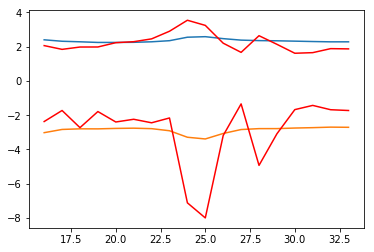

In [23]:
plt.plot(m_vec, train_score)
plt.plot(m_vec, val_score, 'r')


In [12]:
#Test prediction
m_last = 34
X_train = all_data.loc[all_data.date_block_num < m_last].drop(to_drop_cols, axis=1)
y_train = all_data.loc[all_data.date_block_num < m_last, 'target']

X_test = all_data.loc[all_data.date_block_num == m_last].drop(to_drop_cols, axis=1)
#y_val = all_data.loc[all_data.date_block_num == m, 'target']

lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
train_r2_score = r2_score(y_train, y_train_pred)
train_rmse_score = rmse(y_train, y_train_pred)
#val_score[i] = r2_score(y_val, y_val_pred)

print("month %d train r2-score=%f rmse-score=%f" % (m_last, train_r2_score, train_rmse_score))


month 34 train r2-score=0.453261 rmse-score=2.301218


In [44]:
test_submit.shape

(214200, 3)

In [71]:
test_submit = test.copy()
test_submit['item_cnt_month'] = y_test_pred
test_submit.drop(['shop_id', 'item_id'], axis=1, inplace=True)
test_submit.head()

,ID,item_cnt_month
0,0,0.595136
1,1,0.101658
2,2,0.955156
3,3,0.234573
4,4,0.118508


,ID,item_cnt_month
0,0,1.833267
1,1,1.764578
2,2,1.833267
3,3,1.833267
4,4,1.833267


In [72]:
test_submit.to_csv('submit_lr.csv', index=False)

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [68]:
lr = LinearRegression(n_jobs=3)
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.258760


And the we run *LightGBM*.

In [69]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

Test R-squared for LightGBM is 0.296426


Finally, concatenate test predictions to get test meta-features.

In [70]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta-features

**Now it is your turn to write the code**. You need to implement ***scheme f)*** from the reading material. Here, we will use duration **T** equal to month and **M=15**.  

That is, you need to get predictions (meta-features) from *linear regression* and *LightGBM* for months 27, 28, 29, 30, 31, 32. Use the same parameters as in above models.

In [71]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [72]:
dates_train_level2.head()

696174    27
696175    27
696176    27
696177    27
696178    27
Name: date_block_num, dtype: int32

In [73]:
# And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

lr_predict = []
lgb_predict = []

# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    X_train_level1 = X_train[dates_train < cur_block_num].values
    y_train_level1 = y_train[dates_train < cur_block_num]
    
    X_train_cur = X_train[dates_train == cur_block_num].values
    y_train_cur = y_train[dates_train == cur_block_num]
    
    lr.fit(X_train_level1, y_train_level1)
    lr_predict.append(lr.predict(X_train_cur))

    model = lgb.train(lgb_params, lgb.Dataset(X_train_level1, label=y_train_level1), 100)
    lgb_predict.append(model.predict(X_train_cur))
    
X_train_level2 = np.column_stack([np.concatenate(lr_predict, axis=0), np.concatenate(lgb_predict, axis=0)])

# Sanity check
#assert np.all(np.isclose(X_train_level2.mean(axis=0), [ 1.50148988,  1.38811989]))

27
28
29
30
31
32


In [79]:
X_train_level2.mean(axis=0)

array([ 2.22833413,  2.16345193])

In [24]:
X_train_level2.mean(axis=0)

array([ 0.31640942,  0.29100849])

In [51]:
np.r_[range(10), np.ones((3,))]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  1.,  1.,  1.])

In [52]:
np.r_[np.ones((3,)), np.ones((3,))]

array([ 1.,  1.,  1.,  1.,  1.,  1.])

In [155]:
np.c_[np.ones((3,)), np.ones((3,))]

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [150]:
np.row_stack([np.ones((3,)), np.ones((3,))])

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [151]:
np.column_stack([np.ones((3,)), np.ones((3,))])

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [138]:
np.c_[np.ones((3, 1)), np.ones((3, 1))]

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

Remember, the ensembles work best, when first level models are diverse. We can qualitatively analyze the diversity by examinig *scatter plot* between the two metafeatures. Plot the scatter plot below. 

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


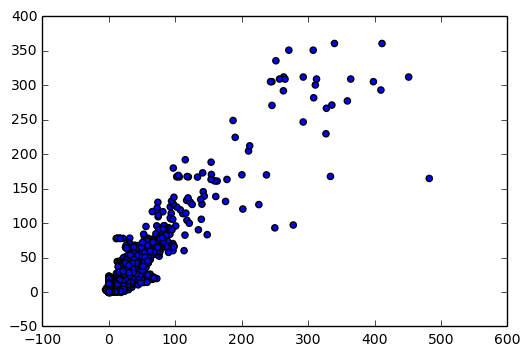

In [36]:
# YOUR CODE GOES HERE
plt.scatter(X_train_level2[:, 0], X_train_level2[:, 1])

# Ensembling

Now, when the meta-features are created, we can ensemble our first level models.

### Simple convex mix

Let's start with simple linear convex mix:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

We need to find an optimal $\alpha$. And it is very easy, as it is feasible to do grid search. Next, find the optimal $\alpha$ out of `alphas_to_try` array. Remember, that you need to use train meta-features (not test) when searching for $\alpha$. 

In [80]:
alphas_to_try = np.linspace(0, 1, 100)

r2_scores = np.zeros(alphas_to_try.shape)
# YOUR CODE GOES HERE
for i, alpha in enumerate(alphas_to_try):
    pred_train_level2 = X_train_level2.dot(np.array([alpha, 1-alpha]).reshape(2, 1)) 
    r2_scores[i] = r2_score(y_train_level2, pred_train_level2)
best_alpha = alphas_to_try[np.argmax(r2_scores)]
r2_train_simple_mix = np.max(r2_scores)

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.202020; Corresponding r2 score on train: 0.271253


Now use the $\alpha$ you've found to compute predictions for the test set 

In [81]:
test_preds = X_test_level2.dot(np.array([best_alpha, 1-best_alpha]).reshape(2, 1))
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.292831


### Stacking

Now, we will try a more advanced ensembling technique. Fit a linear regression model to the meta-features. Use the same parameters as in the model above.

In [82]:
lr = LinearRegression()

In [83]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Compute R-squared on the train and test sets.

In [84]:
train_preds = lr.predict(X_train_level2)
r2_train_stacking = r2_score(y_train_level2, train_preds)

test_preds = lr.predict(X_test_level2)
r2_test_stacking = r2_score(y_test, test_preds)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.271640
Test  R-squared for stacking is 0.298013


In [30]:
lr.coef_

array([ 0.12059072,  0.9346969 ])

Interesting, that the score turned out to be lower than in previous method. Although the model is very simple (just 3 parameters) and, in fact, mixes predictions linearly, it looks like it managed to overfit. **Examine and compare** train and test scores for the two methods. 

And of course this particular case does not mean simple mix is always better than stacking.

We all done! Submit everything we need to the grader now.

In [61]:
from grader import Grader
grader = Grader()

grader.submit_tag('best_alpha', best_alpha)

grader.submit_tag('r2_train_simple_mix', r2_train_simple_mix)
grader.submit_tag('r2_test_simple_mix',  r2_test_simple_mix)

grader.submit_tag('r2_train_stacking', r2_train_stacking)
grader.submit_tag('r2_test_stacking',  r2_test_stacking)

Current answer for task best_alpha is: 0.7647
Current answer for task r2_train_simple_mix is: 0.62725506463
Current answer for task r2_test_simple_mix is: 0.781177285514
Current answer for task r2_train_stacking is: 0.632175561459
Current answer for task r2_test_stacking is: 0.771297132342


In [62]:
STUDENT_EMAIL = 'amnasri@gmail.com'
STUDENT_TOKEN = 'O3dfSMV7L3TlAHPT'
grader.status()

You want to submit these numbers:
Task best_alpha: 0.7647
Task r2_train_simple_mix: 0.62725506463
Task r2_test_simple_mix: 0.781177285514
Task r2_train_stacking: 0.632175561459
Task r2_test_stacking: 0.771297132342


In [63]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
